# EDA of ADNI dataset

In the following EDA, the ADNI dataset (https://www.oasis-brains.org) is studied.

General information about the dataset:
- number of subjects: 831
- number of MRI scans: 2886
- AD classification: 
  - CN (normal control, CDR = 0)
  - MCI (mild cognitive impairment, CDR = 0.5)
  - AD (Alzheimer's disease dementia, CDR = 0.5 or 1)

Besides MRI images, the dataset contains numerical data regarding demographics, various medical assessments, cognitive tests, and brain measurements. 
The numerical parameters that are considered in the EDA (which are relevant to the study of AD and MCI) are:
- demographic parameters:
  - sex
  - age
  - PTEDUCAT: total years of education
- medical assessments:
  - APOE4: APOE gene that is a risk factor for developing AD
  - ABETA: amyloid-beta level in cerebrospinal fluid
  - TAU: tau protein in the cerebrospinal fluid
  - PTAU: phosphorylated tau level in the cerebrospinal fluid 
- cognitive test:
  - ADAS11
  - ADAS13
  - MMSE
  - RAVLT_immediate
- brain volume measurements (obtained from MRI images)
  - Ventricles: volume of the brain ventricles
  - Hippocampus: volume of the hippocampus
  - WholeBrain: whole brain volume
  - Entorhinal: volume of the entorhinal cortex
  
In the first part of the EDA, the numerical data are investigated. 

The second part of the EDA focuses on the image data. 

## Part 1 - Numerical EDA
### Libraries

In [51]:
# import libraries for data analysis and visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import KNN imputer for filling missing values
from sklearn.impute import KNNImputer

# set a colorcode for all the plots 
sns.set_palette(palette='ch:start=.2,rot=-.3')

# set figure size for higher resolution
sns.set(rc={'figure.figsize':(6,3)})
plt.rcParams['figure.dpi'] = 100

# do not show warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Dataset

The ADNI dataset is divided into FreeSurfer data, containing the images along with a csv file containing the demographic information, and numerical data taken from the Tadpole challenge. The subjects with full numerical data (latter) overlap with those with MRI images available (former). However not all patients with the FreeSurfer data have entries in the Tadpole challenge. 

An analysis of the demographic (sex and age) is first carried out using the csv file associated to the FreeSurfer data. The education level is studied later, as this parameter is part of the Tadpole challenge sub-dataset.

In [52]:
# load csv with the demographic associated to the FreeSurfer data
df = pd.read_csv("../data/ADNI_FreeSurfer/FreeSurfer_8_23_2022.csv")

### Data overview

In [53]:
df.head(3)

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I185317,941_S_1363,MCI,F,70,1,MRI,FreeSurfer Cross-Sectional Processing brainmask,Post-processed,3/12/2007,MGH,8/23/2022
1,I185316,941_S_1363,MCI,F,70,1,MRI,FreeSurfer Cross-Sectional Processing aparc+aseg,Post-processed,3/12/2007,MGH,8/23/2022
2,I173268,941_S_1311,MCI,M,69,1,MRI,FreeSurfer Cross-Sectional Processing aparc+aseg,Post-processed,3/02/2007,MGH,8/23/2022


In [54]:
df.tail(3)

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
2883,I252116,002_S_0413,CN,F,76,1,MRI,FreeSurfer Cross-Sectional Processing aparc+aseg,Post-processed,5/02/2006,MGH,8/23/2022
2884,I167591,002_S_0295,CN,M,85,1,MRI,FreeSurfer Cross-Sectional Processing aparc+aseg,Post-processed,4/18/2006,MGH,8/23/2022
2885,I167590,002_S_0295,CN,M,85,1,MRI,FreeSurfer Cross-Sectional Processing brainmask,Post-processed,4/18/2006,MGH,8/23/2022


In [55]:
# number of unique entries for each column
for i in df:
    n = df[i].nunique()
    print(f"{i}: {n}")

Image Data ID: 2886
Subject: 831
Group: 3
Sex: 2
Age: 37
Visit: 1
Modality: 1
Description: 4
Type: 1
Acq Date: 357
Format: 1
Downloaded: 1


### Demographic

The dataset needs first to be rearranged and cleaned up.

In [56]:
# drop columns with just one unique entry
df.drop(["Visit","Modality","Type","Format","Downloaded"],axis=1, inplace=True)

# drop columns irrelevant for demographic analysis
df.drop(["Description","Acq Date"],axis=1, inplace=True)

In [57]:
# rename columns to avoid spaces
df.rename(columns={"Image Data ID":"Image_data_ID"},inplace=True);

In [58]:
# view the first 3 entries of the dataframe
df.head(3)

,Image_data_ID,Subject,Group,Sex,Age
0,I185317,941_S_1363,MCI,F,70
1,I185316,941_S_1363,MCI,F,70
2,I173268,941_S_1311,MCI,M,69


In [59]:
# number of subjects
print(f"Number of studied subjects: {df.Subject.nunique()}")

Number of studied subjects: 831


In [60]:
# number of MRI scans (considering longitudinal and cross-sectional images separately)
print(f"Number of MRI scans: {df.Image_data_ID.nunique()}")

Number of MRI scans: 2886


The dataset contains information about 831 subjects. Each subject has on average about 3.5 MRI images registered in the dataset. For the numerical analysis about the demographic, the entries associated to each MRI image of a single patient are duplicates of no interest and they can be dropped.

In [61]:
# group by subject and remove duplicates
df1 = df.groupby("Subject")
df = df1.max().reset_index()
df.drop("Image_data_ID", axis=1, inplace=True)

In [62]:
# view the first 3 entries of the dataframe
df.head(3)

,Subject,Group,Sex,Age
0,002_S_0295,CN,M,85
1,002_S_0413,CN,F,76
2,002_S_0559,CN,M,79


In [63]:
# view last 3 entries of the dataframe
df.tail(3)

,Subject,Group,Sex,Age
828,941_S_1295,MCI,M,77
829,941_S_1311,MCI,M,69
830,941_S_1363,MCI,F,70


Now each subject has a single row associated to them.

#### Information of studied subjects

The demographic parameters available in the csv file associated to the FreeSurfer data are the subjects' sex, age and presence/absence of AD (given by the parameter Group, with possible entries normal control - CN, mild cognitive impairment - MCI, and Alzheimer's disease - AD). 

**CN, MCI or AD**

The distribution of presence/absence of AD or MCI is first studied.

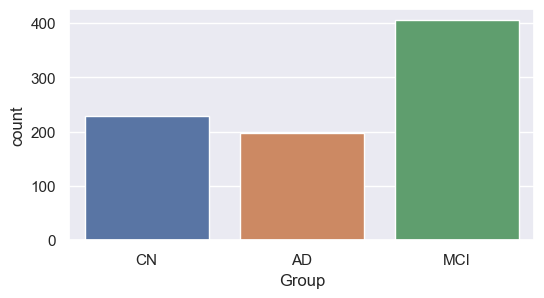

In [64]:
# check distribution of CN, AD and MCI groups
sns.countplot(data = df, x = 'Group');

In [65]:
# check percentage of CN, AD, and MCI groups
df["Group"].value_counts("CN").round(2)

MCI    0.49
CN     0.27
AD     0.24
Name: Group, dtype: float64

27% of the studied subjects are normal controls (CN), 49% have mild cognitive impairment (MCI) and 24% have Alzheimer's disease (AD).

**Sex**

The distribution by subjects' sex is now analysed.

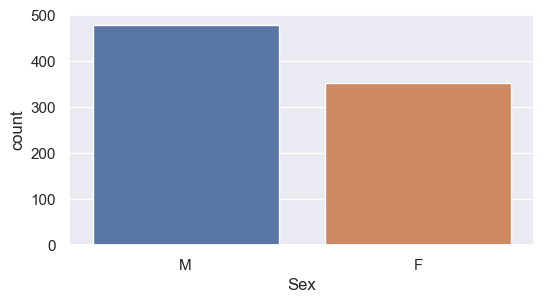

In [66]:
# check distribution of male/female
sns.countplot(data=df, x='Sex');

In [67]:
# check percentage of male/female
df["Sex"].value_counts("M").round(2)

M    0.58
F    0.42
Name: Sex, dtype: float64

The subjects studied are 58% male and 42% female.

**Age**

The age distribution of the subjects is now analysed. For this analysis, the subjects are grouped into 6 age bins for more clarity.

In [68]:
# check age distribution
print(f"min age: {df.Age.min()}; max age: {df.Age.max()}")

# make age bins
df_age = pd.cut(df.Age, bins = 6, labels=["55-61","61-67","67-74","74-80","80-86","86-91"])

# add age bins as a new column to the dataframe 
df=df.join(df_age, how='inner', rsuffix='_category')
df.head(3)


min age: 55; max age: 91


,Subject,Group,Sex,Age,Age_category
0,002_S_0295,CN,M,85,80-86
1,002_S_0413,CN,F,76,74-80
2,002_S_0559,CN,M,79,74-80


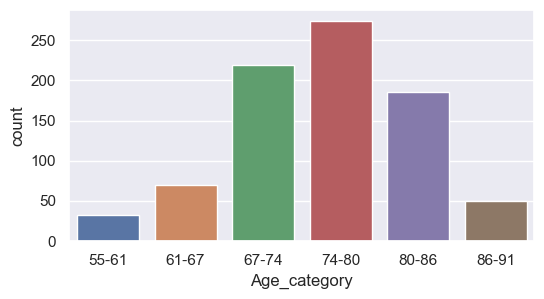

In [69]:
sns.countplot(data = df, x = 'Age_category');

In [70]:
# check percentage of each age category
df["Age_category"].value_counts("80-86").round(2)

74-80    0.33
67-74    0.26
80-86    0.22
61-67    0.08
86-91    0.06
55-61    0.04
Name: Age_category, dtype: float64

The majority of the studied subjects (81%) is between 67 and 86 years old.

**CN, MCI and AD distribution per sex and age**

It can be interesting to see how the disease is distributed between the subjects studied in the data based on their sex and age.

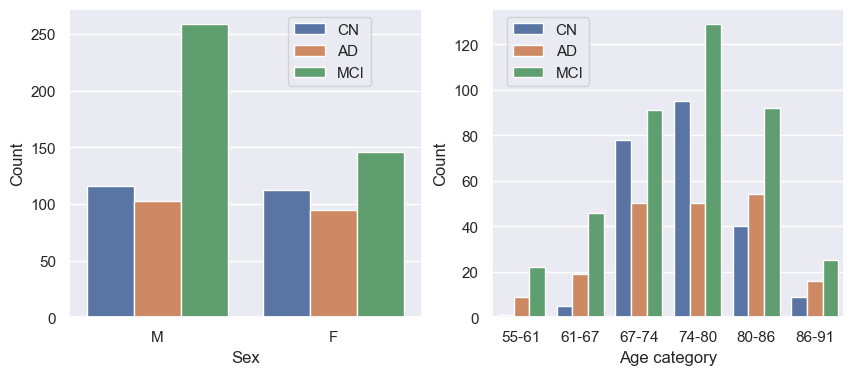

In [71]:
# check distribution of CN, AD and MCI per sex and age category 
fig, axes = plt.subplots(1,2, figsize=(10, 4))
sns.countplot(data=df, x='Sex', hue='Group', ax=axes[0]).set(xlabel='Sex', ylabel='Count')
axes[0].legend(bbox_to_anchor=(0.6, 1), loc='upper left')

sns.countplot(data=df, x='Age_category', hue='Group', ax=axes[1]).set(xlabel='Age category', ylabel='Count')
axes[1].legend(bbox_to_anchor=(0.02, 1), loc='upper left');

In [72]:
# check percentage of male and female subjects for each group
df_group = df.groupby("Group")
df_group.Sex.value_counts("M").round(2)

Group  Sex
AD     M      0.52
       F      0.48
CN     M      0.51
       F      0.49
MCI    M      0.64
       F      0.36
Name: Sex, dtype: float64

51% of the CN subjects, 52% of the AD subjects and 64% of the MCI subjects are male.

In [73]:
# check percentage of each age category
df_group.Age_category.value_counts("80-86").round(2)

Group       
AD     80-86    0.27
       67-74    0.25
       74-80    0.25
       61-67    0.10
       86-91    0.08
       55-61    0.05
CN     74-80    0.42
       67-74    0.34
       80-86    0.18
       86-91    0.04
       61-67    0.02
       55-61    0.00
MCI    74-80    0.32
       80-86    0.23
       67-74    0.22
       61-67    0.11
       86-91    0.06
       55-61    0.05
Name: Age_category, dtype: float64

The majority of CN and MCI subjects is between 74 and 80 year old (42% of CN and 32% of MCI subjects) and the majority of AD subjects is between 80 and 86 years old (27%).

### Education, medical assessments and cognitive tests

The numerical data from the Tadpole challenge are analysed in the following to check for correlations between education, results of the cognitive tests or medical assessments and the diagnosis of AD. Here only data about CN and AD subjects are present (no MCI). 

In [74]:
# load functions to get the dataset and process it 
sys.path.append('../')
from preprocessing.getdata import get_csvdata, get_tadpole, drop_tadpole, col_tadpole

# import dataset using get_tadpole function
df_tad = get_tadpole()
df_tad.head(3)

,RID,ID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,label
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,1.36665,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,22.83,1.08355,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,1
10,5,011_S_0005,bl,11,ADNI1,ADNI1,2005-09-07,CN,73.7,Male,...,33.43,1.29343,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0


The parameter label indicates the presence/absence of AD and the entries correspond to CN (=0) and AD (=1). The entries are generated by the function get_tadpole as needed for the modelling. For now, these are left as they are (0s and 1s) since a KNN inputer is used for inputing some of the null values. 

In [75]:
# check number of different IDs (number of different patients)
df_tad["ID"].nunique()

417

In [76]:
# available parameters in the dataset
df_tad.columns

Index(['RID', 'ID', 'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER',
       ...
       'PTAU_bl', 'FDG_bl', 'PIB_bl', 'AV45_bl', 'Years_bl', 'Month_bl',
       'Month', 'M', 'update_stamp', 'label'],
      dtype='object', length=114)

Various parameters are irrelevant for studying dementia or are not explained and can be dropped.

In [77]:
# drop unnecessary columns and columns with unknown meaning
df_tad=drop_tadpole(df_tad)

In [78]:
# check number of null values for each parameter
df_tad.isnull().sum()

ID                   0
AGE                  0
PTGENDER             0
PTEDUCAT             0
APOE4                0
ABETA              208
TAU                208
PTAU               208
ADAS11               1
ADAS13               5
MMSE                 0
RAVLT_immediate      4
Ventricles           7
Hippocampus         72
WholeBrain           4
Entorhinal          72
label                0
dtype: int64

Almost half of the ABETA, TAU and PTAU parameters have null entries. The entire columns are thus dropped.

In [ ]:
# drop columns with large number of null values
df_tad.drop(["ABETA","TAU","PTAU"], inplace = True, axis = 1)

# ID does not carry any relevant information
# PTGENDER corresponds to the Sex column in the previous EDA, and has already been analysed
# Both can be thus dropped (they would cause issues with the KNN imputer)
df_tad.drop(["ID","PTGENDER"], inplace = True, axis = 1)

The remaining values can be predicted and inputed using KNN nearest neighbor imputer.

In [ ]:
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(df_tad)

# transform df_tad
df_tad = imputer.transform(df_tad)

# convert df_tad into a dataframe 
df_tad = pd.DataFrame(df_tad)

# rename columns with the original names
df_tad.columns = ['AGE', 'PTEDUCAT', 'APOE4', 'ADAS11', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'Ventricles', 'Hippocampus', 'WholeBrain',
       'Entorhinal', 'Group']

Now that there is no null value and no modelling is needed for the EDA, the entries of the column label (renamed Group) can be changed back into CN or AD for consistency with the previous EDA.

In [ ]:
# replace 0 with CN and 1 with AD in the Group column
df_tad.label = df_tad.Group.replace(to_replace=[0,1], value=["CN","AD"], inplace = True)

In [ ]:
# view the first 3 rows of the dataframe
df_tad.head(3)

,AGE,PTEDUCAT,APOE4,ADAS11,ADAS13,MMSE,RAVLT_immediate,Ventricles,Hippocampus,WholeBrain,Entorhinal,Group
0,74.3,16.0,0.0,10.67,18.67,28.0,44.0,118233.0,8336.0,1229740.0,4177.0,CN
1,81.3,18.0,1.0,22.00,31.00,20.0,22.0,84599.0,5319.0,1129830.0,1791.0,AD
2,73.7,16.0,0.0,8.67,14.67,29.0,37.0,34062.0,7075.0,1116630.0,4433.0,CN


In [ ]:
# number of unique entries for each column
for i in df_tad:
    n = df_tad[i].nunique()
    print(f"{i}: {n}")

AGE: 194
PTEDUCAT: 16
APOE4: 3
ADAS11: 89
ADAS13: 122
MMSE: 12
RAVLT_immediate: 63
Ventricles: 417
Hippocampus: 403
WholeBrain: 417
Entorhinal: 402
Group: 2


The dataset is now clean and the analysis can be performed.

**Education**

First, the number of education years is checked against the presence/absence of AD in subjects.

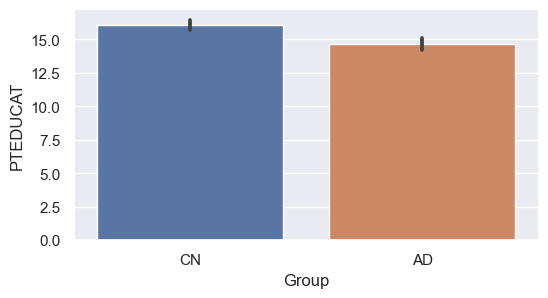

In [ ]:
# plot total number of education years per group
sns.barplot(data=df_tad,x="Group",y="PTEDUCAT");

A lower number of education years appears to be related to the formation of AD.

**Medical assessments**

Due to the high number of missing values, all the medical assessments apart from the APOE4 were dropped. Here the APOE4 parameter is analysed.

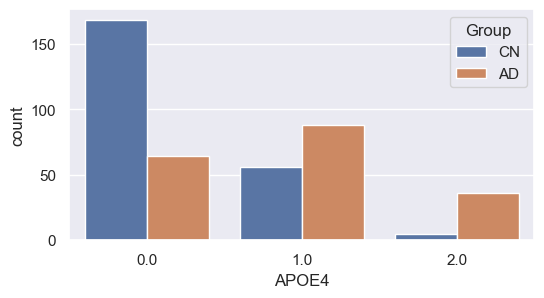

In [ ]:
# plot count of CN and AD subjects for each APOE4 value
sns.countplot(data = df_tad, x = "APOE4", hue = "Group");

A score of APOE4 = 0 is more common among CN subjects considered in the dataset. Subjects with higher scores of APOE4 (1 and 2) are likely to have AD (also taking into account the lower number of AD patients compared to the CN subjects).

**Cognitive tests**

Here the cognitive tests ADAS11, ADAS13, MMSE and RAVLT are analysed.

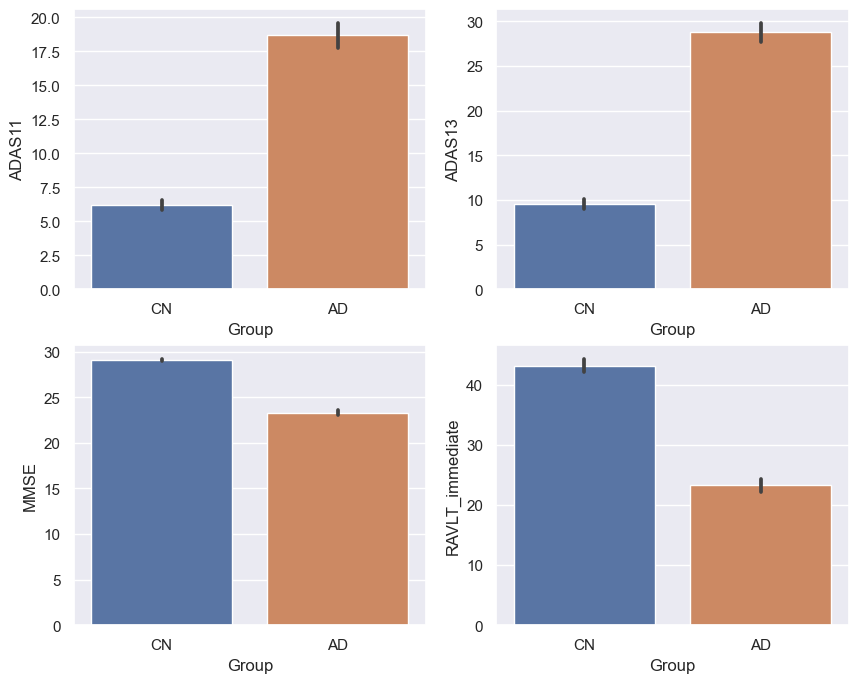

In [ ]:
# plot the mean ADAS11, ADAS13, MMSE and RAVLT_immediate for CN and AD groups 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.barplot(data=df_tad, x='Group', y="ADAS11", ax=axes[0,0])
sns.barplot(data=df_tad, x='Group', y="ADAS13", ax=axes[0,1])
sns.barplot(data=df_tad, x='Group', y="MMSE", ax=axes[1,0])
sns.barplot(data=df_tad, x='Group', y="RAVLT_immediate", ax=axes[1,1]);

Both a higher value of ADAS11 (between 17.5 and 20) and of ADAS13 (in the range of 27 and 30) is linked to AD. On the other hand, AD is linked to lower scores of MMSE (between 23 and 24) and of RAVLT_immediate (between 21 and 24).

**Brain measurements**

An analysis of the brain measurements follows. The values in the datasets are extracted from the MRI images that are described later.

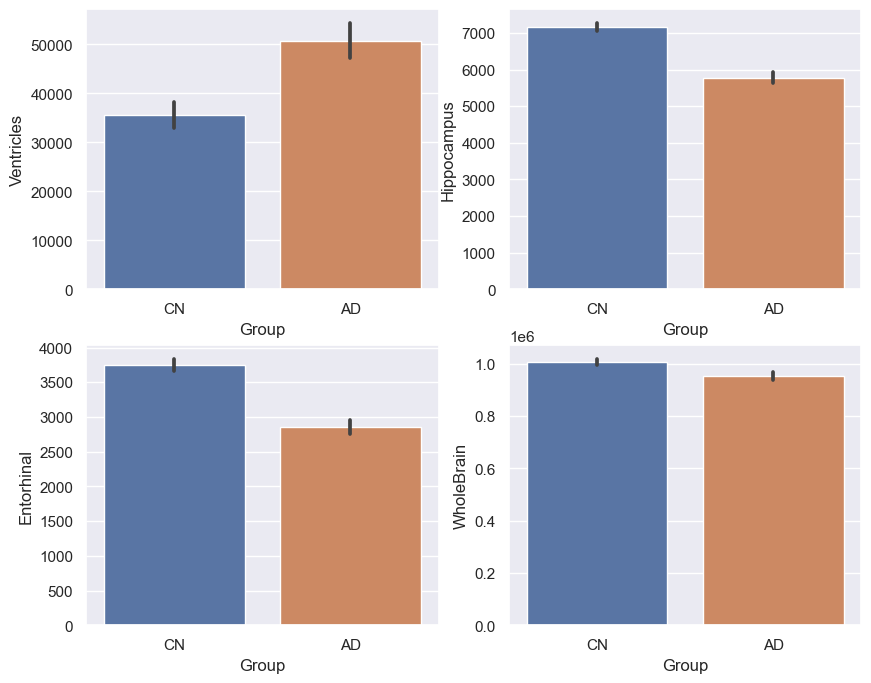

In [ ]:
# plot the mean Ventricles, Hippocampus, WholeBrain and Entorhinal for CN and AD groups 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.barplot(data=df_tad, x='Group', y="Ventricles", ax=axes[0,0])
sns.barplot(data=df_tad, x='Group', y="Hippocampus", ax=axes[0,1])
sns.barplot(data=df_tad, x='Group', y="WholeBrain", ax=axes[1,1])
sns.barplot(data=df_tad, x='Group', y="Entorhinal", ax=axes[1,0]);

The ventricles size is larger for AD subjects than for subjects in the CN group. The volume of the hippocampus, the entorhinal cortex and, in general, the volume of the brain as a whole, reduces as a person develops Alzheimer's disease. 

## Part 2 - Image EDA

In the following, the FreeSurfer MRI images are studied.

### Libaries and script

In [ ]:
# run script for importing brain slices
from preprocessing.getdata import *

### Dataset

In [ ]:
# full dataset after numerical EDA
df.head()

,Subject,Group,Sex,Age,Age_category
0,002_S_0295,CN,M,85,80-86
1,002_S_0413,CN,F,76,74-80
2,002_S_0559,CN,M,79,74-80
3,002_S_0619,AD,M,78,74-80
4,002_S_0685,CN,F,90,86-91


In [ ]:
# make separate dataframes for plotting

# split df by groups
df_CN = df[df.Group=="CN"]
df_AD = df[df.Group=="AD"]
df_MCI = df[df.Group=="MCI"]

# split df by gender for each group
df_CN_M = df_CN[df.Sex=="M"]
df_CN_F = df_CN[df.Sex=="F"]
df_AD_M = df_AD[df.Sex=="M"]
df_AD_F = df_AD[df.Sex=="F"]
df_MCI_M = df_MCI[df.Sex=="M"]
df_MCI_F = df_MCI[df.Sex=="F"]

# split df by age category for each group (make only 3 categories: 55-67, 68-79 and 80-91)
df_CN_55to67 = df_CN[df.Age<=67]
df_CN_68to79 = df_CN[(df.Age>68) & (df.Age<=79)]
df_CN_80to91 = df_CN[(df.Age>80) & (df.Age<=91)]
df_AD_55to67 = df_AD[df.Age<=67]
df_AD_68to79 = df_AD[(df.Age>68) & (df.Age<=79)]
df_AD_80to91 = df_AD[(df.Age>80) & (df.Age<=91)]
df_MCI_55to67 = df_MCI[df.Age<=67]
df_MCI_68to79 = df_MCI[(df.Age>68) & (df.Age<=79)]
df_MCI_80to91 = df_MCI[(df.Age>80) & (df.Age<=91)]


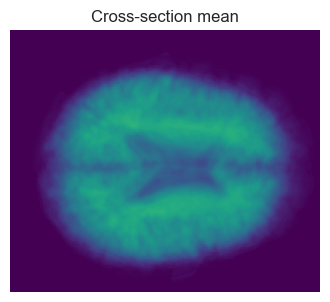

In [ ]:
# mean of cross-sectional images
img_a = get_slices_ADNI(df["Subject"][:30], N=0, dim=2, normalize=True, m=100) # average of the N-M images (...["ID"][M:N],..)
from EDA_functions import *
img_mean(img_a, vmax=1, title="Cross-section mean")

Comparison of brain slices of NC, MCI and AD subjects:

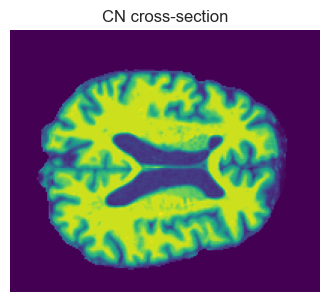

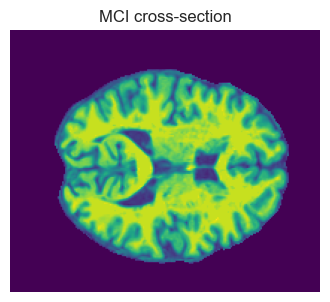

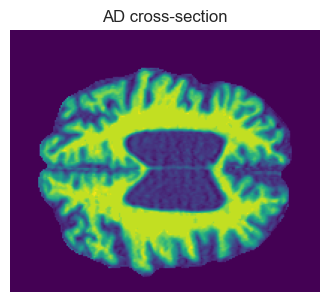

In [ ]:
# comparison of example (or mean) brain slices of CN, MCI and AD
img_a = get_slices_ADNI(df_CN["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
img_b = get_slices_ADNI(df_MCI["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
img_c = get_slices_ADNI(df_AD["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
from EDA_functions import *
img_mean(img_a, vmax=1, title="CN cross-section")
img_mean(img_b, vmax=1, title="MCI cross-section")
img_mean(img_c, vmax=1, title="AD cross-section")

#### Influence of sex

Influence of sex in CN subjects:

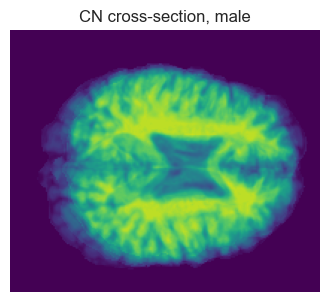

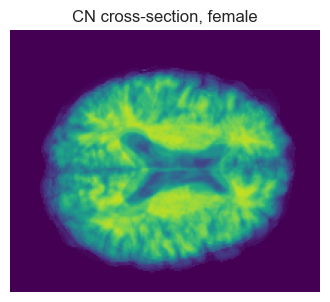

In [ ]:
# comparison of mean brain slices of male and female CN subjects
img_a = get_slices_ADNI(df_CN_M["Subject"][:5], N=0, dim=2, normalize=True, m=100) 
img_b = get_slices_ADNI(df_CN_F["Subject"][:5], N=0, dim=2, normalize=True, m=100) 
from EDA_functions import *
img_mean(img_a, vmax=1, title="CN cross-section, male")
img_mean(img_b, vmax=1, title="CN cross-section, female")

Influence of sex in MCI subjects:

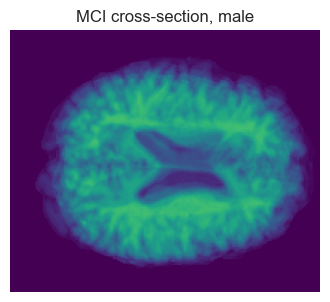

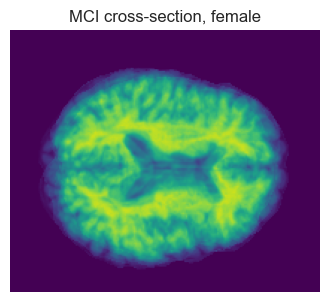

In [ ]:
# comparison of mean brain slices of male and female MCI subjects
img_a = get_slices_ADNI(df_MCI_M["Subject"][:5], N=0, dim=2, normalize=True, m=100) 
img_b = get_slices_ADNI(df_MCI_F["Subject"][:5], N=0, dim=2, normalize=True, m=100) 
from EDA_functions import *
img_mean(img_a, vmax=1, title="MCI cross-section, male")
img_mean(img_b, vmax=1, title="MCI cross-section, female")

Influence of sex in AD subjects:

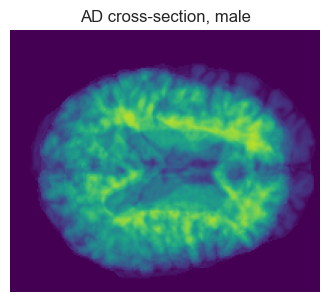

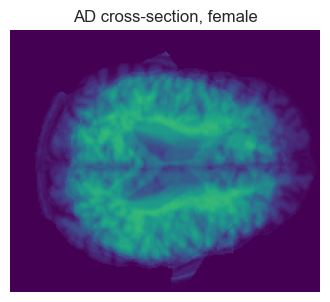

In [ ]:
# comparison of mean brain slices of male and female AD subjects
img_a = get_slices_ADNI(df_AD_M["Subject"][:5], N=0, dim=2, normalize=True, m=100) 
img_b = get_slices_ADNI(df_AD_F["Subject"][:5], N=0, dim=2, normalize=True, m=100) 
from EDA_functions import *
img_mean(img_a, vmax=1, title="AD cross-section, male")
img_mean(img_b, vmax=1, title="AD cross-section, female")

#### Influence of age

Influence of age in CN subjects:

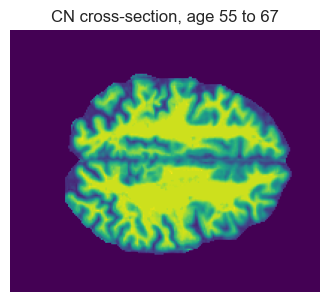

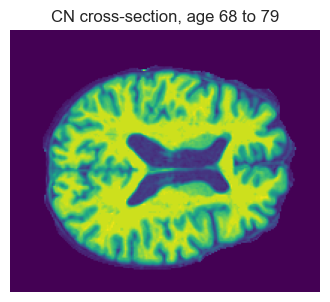

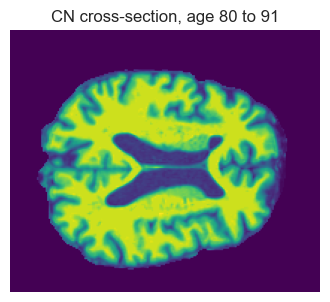

In [ ]:
# comparison of example (or mean) brain slices of CN subjects for 3 age categories
img_a = get_slices_ADNI(df_CN_55to67["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
img_b = get_slices_ADNI(df_CN_68to79["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
img_c = get_slices_ADNI(df_CN_80to91["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
from EDA_functions import *
img_mean(img_a, vmax=1, title="CN cross-section, age 55 to 67")
img_mean(img_b, vmax=1, title="CN cross-section, age 68 to 79")
img_mean(img_c, vmax=1, title="CN cross-section, age 80 to 91")

Influence of age in MCI subjects:

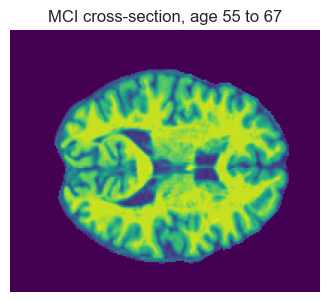

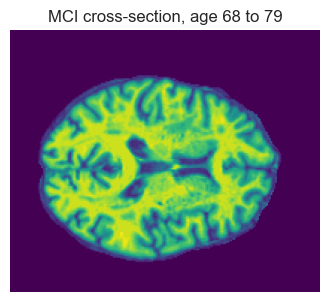

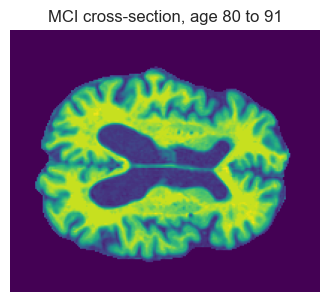

In [ ]:
# comparison of example (or mean) brain slices of MCI subjects for 3 age categories
img_a = get_slices_ADNI(df_MCI_55to67["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
img_b = get_slices_ADNI(df_MCI_68to79["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
img_c = get_slices_ADNI(df_MCI_80to91["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
from EDA_functions import *
img_mean(img_a, vmax=1, title="MCI cross-section, age 55 to 67")
img_mean(img_b, vmax=1, title="MCI cross-section, age 68 to 79")
img_mean(img_c, vmax=1, title="MCI cross-section, age 80 to 91")

Influence of age in AD subjects:

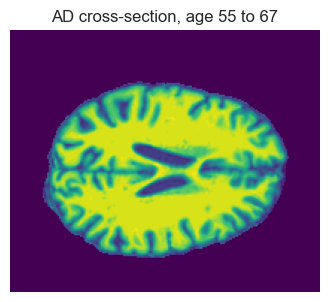

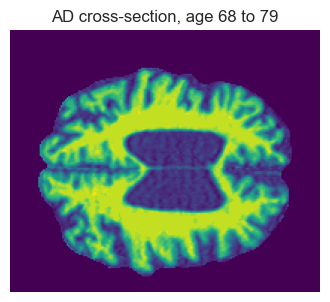

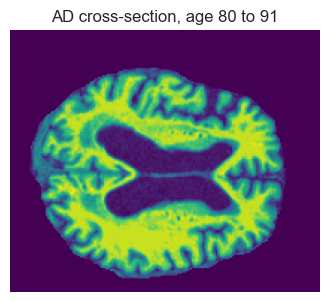

In [ ]:
# comparison of example (or mean) brain slices of AD subjects for 3 age categories
img_a = get_slices_ADNI(df_AD_55to67["Subject"][2:3], N=0, dim=2, normalize=True, m=100) 
img_b = get_slices_ADNI(df_AD_68to79["Subject"][:1], N=0, dim=2, normalize=True, m=100) 
img_c = get_slices_ADNI(df_AD_80to91["Subject"][2:3], N=0, dim=2, normalize=True, m=100) 
from EDA_functions import *
img_mean(img_a, vmax=1, title="AD cross-section, age 55 to 67")
img_mean(img_b, vmax=1, title="AD cross-section, age 68 to 79")
img_mean(img_c, vmax=1, title="AD cross-section, age 80 to 91")